# [심화과제] 예측 모델에 deep learning techniques 적용하기

- CIFAR-10 데이터셋은 10개의 클래스로 구성된 60,000개의 32x32 컬러 이미지입니다.
- 각 클래스당 6,000개의 이미지가 있습니다. 
- 50,000개의 훈련용 이미지와 10,000개의 테스트용 이미지로 구성되어 있습니다.
- 다음은 데이터셋의 클래스들입니다.
    - 레이블 0: 비행기
    - 레이블 1: 자동차
    - 레이블 2: 새
    - 레이블 3: 고양이
    - 레이블 4: 사슴
    - 레이블 5: 개
    - 레이블 6: 개구리
    - 레이블 7: 말
    - 레이블 8: 배
    - 레이블 9: 트럭
- [참고 링크](https://www.cs.toronto.edu/~kriz/cifar.html)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
DIR_ROOT_DATA = "./data"

CIFAR_BATCH_SIZE = 256
CIFAR_NUM_EPOCHS = 50
CIFAR_LEARNING_RATE = 0.001

## 편의 기능 함수
- 사용 가능한 torch.device 가져오는 함수
- 모델에 대해서, 정확도를 계산해주는 함수

In [3]:
def get_device() -> torch.device:
    """
    mps, cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def calculate_accuracy(
    device: torch.device, model: nn.Module, data_loader: torch.utils.data.DataLoader
) -> float:
    """
    model 에 대한 평가를 진행하여, 예측의 정확도를 계산
    :return: 정확도
    """
    total = 0
    num_correctness = 0

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            inputs, labels = images.to(device), labels.to(device)

            outputs = model(inputs)

            total += labels.size(0)

            predictions = torch.argmax(outputs, dim=1)
            num_correctness += (predictions == labels).sum().item()
    model.train()

    return num_correctness / total

In [4]:
transform = transforms.ToTensor()

cifar_train_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=True, download=True, transform=transform
)
cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train_set,
    batch_size=CIFAR_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

cifar_test_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=False, download=True, transform=transform
)
cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test_set, batch_size=CIFAR_BATCH_SIZE, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


## 예시 이미지
- CIFAR 10 데이터셋 중 이미지 한 개를 확인해보겠습니다.

shape of cifar_images: torch.Size([256, 3, 32, 32])
label: 3 which is: 고양이


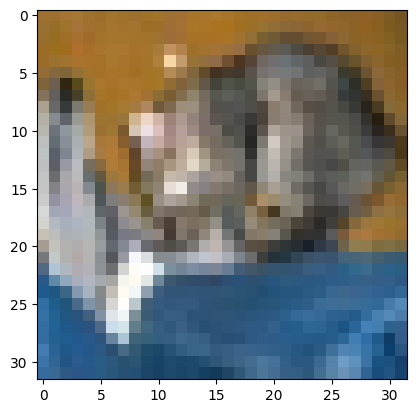

In [5]:
# 레이블에 해당하는 종류를 글자로 바꿀 수 있도록 tuple 을 준비
names = ("비행기", "자동차", "새", "고양이", "사슴", "개", "개구리", "말", "배", "트럭")

cifar_images, cifar_labels = next(iter(cifar_test_loader))

print("shape of cifar_images:", cifar_images.shape)

print("label:", cifar_labels[0].item(), "which is:", names[cifar_labels[0].item()])
plt.imshow(transforms.ToPILImage()(cifar_images[0]))

## CIFAR10 데이터 분류 모델 정의

In [6]:
class SimpleImageClassificationModel(nn.Module):
    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel, self).__init__()
        hidden_dim = 1024

        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, num_output_class)

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer3(x))  # x.shape: (batch_size, 2048)
        x = self.layer4(x)  # x.shape: (batch_size, num_output_classes)
        return x

In [7]:
device = get_device()
device

device(type='mps')

In [8]:
cifar_model_for_sgd = SimpleImageClassificationModel(3, 32, 32, 10).to(device)
cifar_model_for_sgd

SimpleImageClassificationModel(
  (layer1): Linear(in_features=3072, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [9]:
cifar_model_for_adam = SimpleImageClassificationModel(3, 32, 32, 10).to(device)
cifar_model_for_adam

SimpleImageClassificationModel(
  (layer1): Linear(in_features=3072, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)

In [10]:
cifar_sdg_optimizer = optim.SGD(
    cifar_model_for_sgd.parameters(), lr=CIFAR_LEARNING_RATE
)
cifar_sdg_optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [11]:
cifar_adam_optimizer = optim.Adam(
    cifar_model_for_adam.parameters(), lr=CIFAR_LEARNING_RATE
)
cifar_adam_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [12]:
cifar_criterion = nn.CrossEntropyLoss()
cifar_criterion

CrossEntropyLoss()

## 학습
- 매 epoch 마다의 모델을 가지고, train 데이터와 test 데이터에 대한 정확도 측정

In [13]:
cifar_accuracies = np.zeros(
    (2, 2, CIFAR_NUM_EPOCHS)
)  # (optimizer 별, data 종류 별, epoch 마다)

### optimizer 가 sdg 일 때 학습

In [14]:
for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_sdg_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_for_sgd(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_sdg_optimizer.step()

    cifar_accuracies[0][0][epoch] = calculate_accuracy(
        device, cifar_model_for_sgd, cifar_train_loader
    )
    cifar_accuracies[0][1][epoch] = calculate_accuracy(
        device, cifar_model_for_sgd, cifar_test_loader
    )

    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_accuracies[0][0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.11730
Epoch   2, Training Accuracy: 0.10956
Epoch   3, Training Accuracy: 0.10716
Epoch   4, Training Accuracy: 0.10686
Epoch   5, Training Accuracy: 0.10774
Epoch   6, Training Accuracy: 0.11038
Epoch   7, Training Accuracy: 0.11510
Epoch   8, Training Accuracy: 0.12054
Epoch   9, Training Accuracy: 0.12674
Epoch  10, Training Accuracy: 0.13638
Epoch  11, Training Accuracy: 0.14560
Epoch  12, Training Accuracy: 0.15444
Epoch  13, Training Accuracy: 0.16446
Epoch  14, Training Accuracy: 0.17280
Epoch  15, Training Accuracy: 0.17922
Epoch  16, Training Accuracy: 0.18704
Epoch  17, Training Accuracy: 0.19540
Epoch  18, Training Accuracy: 0.20332
Epoch  19, Training Accuracy: 0.20780
Epoch  20, Training Accuracy: 0.21304
Epoch  21, Training Accuracy: 0.21766
Epoch  22, Training Accuracy: 0.21776
Epoch  23, Training Accuracy: 0.22204
Epoch  24, Training Accuracy: 0.22408
Epoch  25, Training Accuracy: 0.22686
Epoch  26, Training Accuracy: 0.22782
Epoch  27, T

### optimizer 가 Adam 일 때 학습

In [15]:
for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_adam_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_for_adam(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_adam_optimizer.step()

    cifar_accuracies[1][0][epoch] = calculate_accuracy(
        device, cifar_model_for_adam, cifar_train_loader
    )
    cifar_accuracies[1][1][epoch] = calculate_accuracy(
        device, cifar_model_for_adam, cifar_test_loader
    )

    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_accuracies[1][0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.37140
Epoch   2, Training Accuracy: 0.40422
Epoch   3, Training Accuracy: 0.44366
Epoch   4, Training Accuracy: 0.47950
Epoch   5, Training Accuracy: 0.47972
Epoch   6, Training Accuracy: 0.50424
Epoch   7, Training Accuracy: 0.51140
Epoch   8, Training Accuracy: 0.49734
Epoch   9, Training Accuracy: 0.54276
Epoch  10, Training Accuracy: 0.56040
Epoch  11, Training Accuracy: 0.56262
Epoch  12, Training Accuracy: 0.58076
Epoch  13, Training Accuracy: 0.59150
Epoch  14, Training Accuracy: 0.61422
Epoch  15, Training Accuracy: 0.62114
Epoch  16, Training Accuracy: 0.65960
Epoch  17, Training Accuracy: 0.66476
Epoch  18, Training Accuracy: 0.67188
Epoch  19, Training Accuracy: 0.70350
Epoch  20, Training Accuracy: 0.72138
Epoch  21, Training Accuracy: 0.74376
Epoch  22, Training Accuracy: 0.76790
Epoch  23, Training Accuracy: 0.78474
Epoch  24, Training Accuracy: 0.81020
Epoch  25, Training Accuracy: 0.82726
Epoch  26, Training Accuracy: 0.84056
Epoch  27, T

## Optimizer 별 Accuracy 그래프

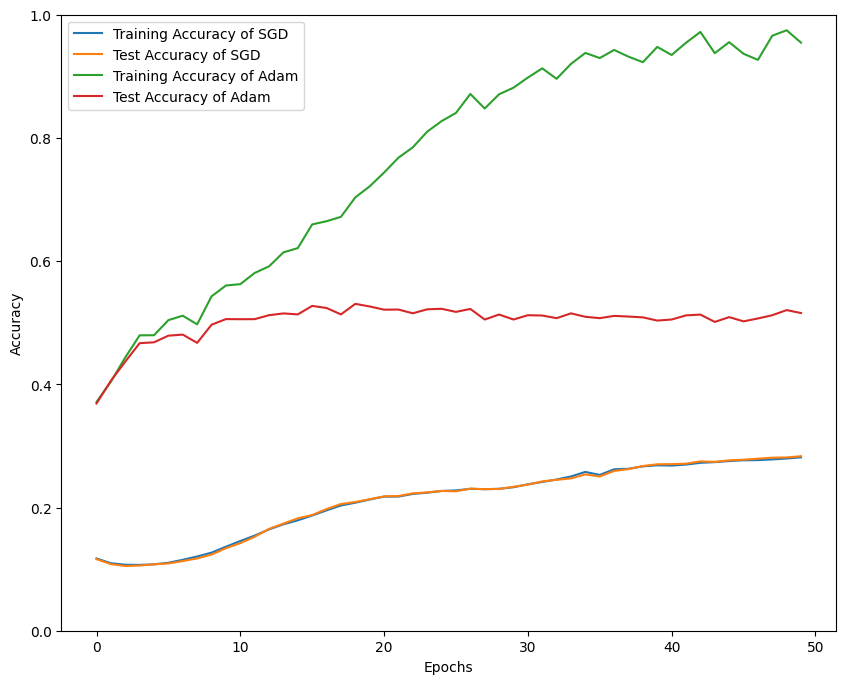

In [16]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[0][0], label="Training Accuracy of SGD")
plt.plot(x_axis, cifar_accuracies[0][1], label="Test Accuracy of SGD")
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy of Adam")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy of Adam")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- Adam optimizer 를 사용했을 때, 정확도가 더 높았다.
- 하지만, train 데이터셋과 test 데이터셋 간의 정확도 차이를 봤을 때, overfitting 문제가 발생했다는 것을 알 수 있다. 

## Sigmoid 를 활성 함수로 적용한 분류 모델

In [17]:
class SimpleImageClassificationModel02(nn.Module):
    """
    활성 함수로 Sigmod 를 사용하는 분류 모델
    """

    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel02, self).__init__()

        hidden_dim = 1024
        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, num_output_class)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer3(x))  # x.shape: (batch_size, 2048)
        x = self.layer4(x)  # x.shape: (batch_size, num_output_classes)
        return x

### 학습

In [18]:
cifar_model_02 = SimpleImageClassificationModel02(3, 32, 32, 10).to(device)
cifar_model_02_optimizer = optim.Adam(
    cifar_model_02.parameters(), lr=CIFAR_LEARNING_RATE
)

cifar_model_02_accuracies = np.zeros((2, CIFAR_NUM_EPOCHS))

for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_model_02_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_02(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_model_02_optimizer.step()
    cifar_model_02_accuracies[0][epoch] = calculate_accuracy(
        device, cifar_model_02, cifar_train_loader
    )
    cifar_model_02_accuracies[1][epoch] = calculate_accuracy(
        device, cifar_model_02, cifar_test_loader
    )
    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_model_02_accuracies[0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.22372
Epoch   2, Training Accuracy: 0.34030
Epoch   3, Training Accuracy: 0.37572
Epoch   4, Training Accuracy: 0.40772
Epoch   5, Training Accuracy: 0.42614
Epoch   6, Training Accuracy: 0.45298
Epoch   7, Training Accuracy: 0.43916
Epoch   8, Training Accuracy: 0.47228
Epoch   9, Training Accuracy: 0.47312
Epoch  10, Training Accuracy: 0.48910
Epoch  11, Training Accuracy: 0.49350
Epoch  12, Training Accuracy: 0.49364
Epoch  13, Training Accuracy: 0.52620
Epoch  14, Training Accuracy: 0.52140
Epoch  15, Training Accuracy: 0.54046
Epoch  16, Training Accuracy: 0.54948
Epoch  17, Training Accuracy: 0.54980
Epoch  18, Training Accuracy: 0.54946
Epoch  19, Training Accuracy: 0.56686
Epoch  20, Training Accuracy: 0.57360
Epoch  21, Training Accuracy: 0.53592
Epoch  22, Training Accuracy: 0.56638
Epoch  23, Training Accuracy: 0.57646
Epoch  24, Training Accuracy: 0.58048
Epoch  25, Training Accuracy: 0.57768
Epoch  26, Training Accuracy: 0.60872
Epoch  27, T

## LeakyReLu 와 Sigmoid 활성 함수 별 분류 모델 정확도 그래프  

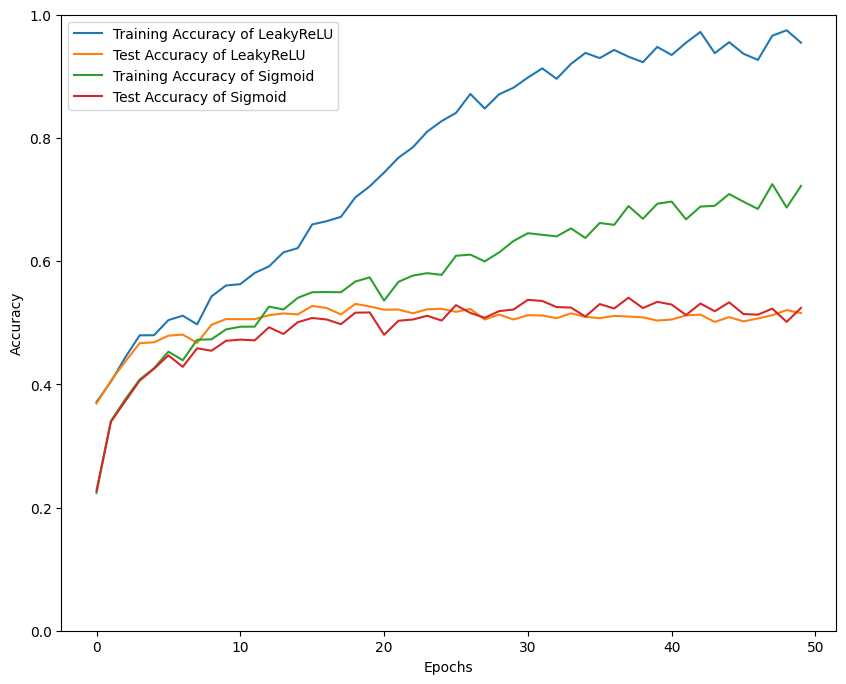

In [19]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy of LeakyReLU")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy of LeakyReLU")
plt.plot(x_axis, cifar_model_02_accuracies[0], label="Training Accuracy of Sigmoid")
plt.plot(x_axis, cifar_model_02_accuracies[1], label="Test Accuracy of Sigmoid")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- LeakyReLU 모델이 Sigmoid 모델보다 훈련 데이터에 대해 더 높은 정확도를 달성합니다.
- 그러나 테스트 정확도는 두 모델이 비슷한 수준을 보입니다.
- 즉, LeakyReLU 모델이 더 심한 과적합 현상을 보입니다.
- 두 모델 모두 overfitting 문제가 있습니다.

## Dropout 을 적용한 분류 모델

In [20]:
class SimpleImageClassificationModel03(nn.Module):
    """
    dropout 을 사용하는 분류 모델
    """

    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel03, self).__init__()

        hidden_dim = 1024
        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, num_output_class)

        self.dropout = nn.Dropout(p=0.1)

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.dropout(self.layer1(x)))  # x.shape: (batch_size, 2048)
        x = self.activation(self.dropout(self.layer2(x)))  # x.shape: (batch_size, 2048)
        x = self.activation(self.dropout(self.layer3(x)))  # x.shape: (batch_size, 2048)
        x = self.layer4(x)  # x.shape: (batch_size, num_output_classes)
        return x

### 학습

In [21]:
cifar_model_03 = SimpleImageClassificationModel03(3, 32, 32, 10).to(device)
cifar_model_03_optimizer = optim.Adam(
    cifar_model_03.parameters(), lr=CIFAR_LEARNING_RATE
)

cifar_model_03_accuracies = np.zeros((2, CIFAR_NUM_EPOCHS))

for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_model_03_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outpust = cifar_model_03(inputs)

        loss = cifar_criterion(outpust, labels)
        loss.backward()

        cifar_model_03_optimizer.step()

    cifar_model_03_accuracies[0][epoch] = calculate_accuracy(
        device, cifar_model_03, cifar_train_loader
    )
    cifar_model_03_accuracies[1][epoch] = calculate_accuracy(
        device, cifar_model_03, cifar_test_loader
    )
    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_model_03_accuracies[0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.35908
Epoch   2, Training Accuracy: 0.41160
Epoch   3, Training Accuracy: 0.42864
Epoch   4, Training Accuracy: 0.46676
Epoch   5, Training Accuracy: 0.46236
Epoch   6, Training Accuracy: 0.48960
Epoch   7, Training Accuracy: 0.50618
Epoch   8, Training Accuracy: 0.52082
Epoch   9, Training Accuracy: 0.52850
Epoch  10, Training Accuracy: 0.53186
Epoch  11, Training Accuracy: 0.54782
Epoch  12, Training Accuracy: 0.55670
Epoch  13, Training Accuracy: 0.56534
Epoch  14, Training Accuracy: 0.57588
Epoch  15, Training Accuracy: 0.55608
Epoch  16, Training Accuracy: 0.58594
Epoch  17, Training Accuracy: 0.60316
Epoch  18, Training Accuracy: 0.59740
Epoch  19, Training Accuracy: 0.61772
Epoch  20, Training Accuracy: 0.61364
Epoch  21, Training Accuracy: 0.62364
Epoch  22, Training Accuracy: 0.65154
Epoch  23, Training Accuracy: 0.65568
Epoch  24, Training Accuracy: 0.67384
Epoch  25, Training Accuracy: 0.69022
Epoch  26, Training Accuracy: 0.69290
Epoch  27, T

## Dropout 적용 유무 별 분류 모델 정확도 그래프 

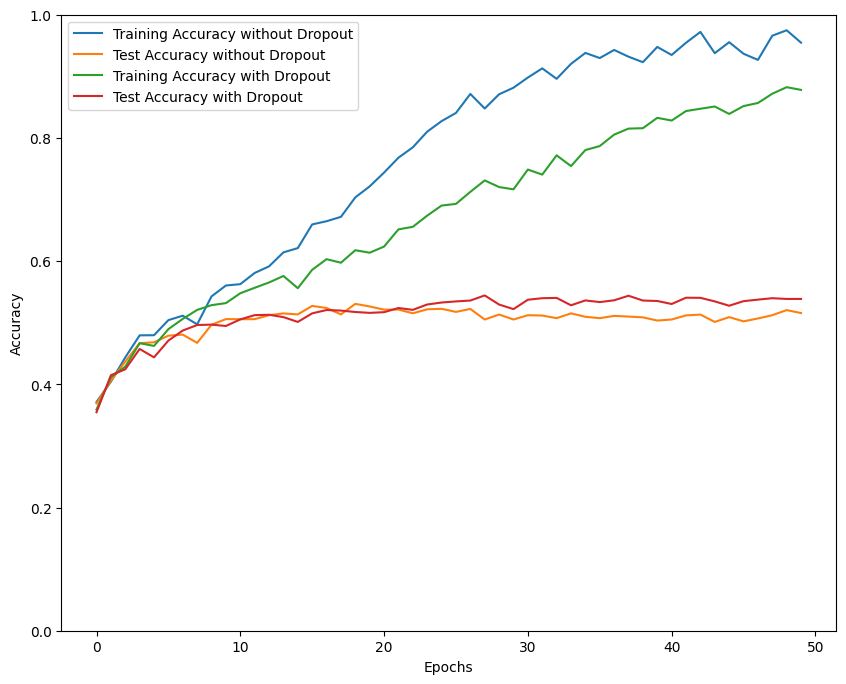

In [22]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy without Dropout")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy without Dropout")
plt.plot(x_axis, cifar_model_03_accuracies[0], label="Training Accuracy with Dropout")
plt.plot(x_axis, cifar_model_03_accuracies[1], label="Test Accuracy with Dropout")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- Dropout 을 적용한 모델이, 적용하지 않은 모델 보다 과적합을 어느정도 방지했습니다.
- 그러나 여전히 과적합 문제가 심합니다. 